# Données Nutritionnelles : Nettoyage des données et feature engineering

#### Initialisation

In [1]:
%matplotlib inline
import pandas as pd
import csv as csv
import numpy as np 
import matplotlib.pyplot as plt
import os as os
import seaborn as sns 
from random import sample
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Imputer
from scipy import stats
# from bokeh.charts import Scatter, output_file, show

plt.style.use('seaborn-notebook')
sns.set_style('ticks')
sns.set(rc={'figure.figsize':(12,8)})
sns.set(rc={'font.size':24})

os.getcwd()
os.chdir("C:/Users/flemeill/Documents/01 - Projets OC/02 - Projet 2/Main project")

#### Import des données et première visualisation de 5 produits aléatoires

In [2]:
data = pd.read_csv("fr.openfoodfacts.org.products.csv", sep='\t', low_memory=False)

# Create a random index
randomIndex = np.array(sample(range(len(data)), 5))

# Get 5 random rows
Sample = data.loc[randomIndex]

# Print the sample
print(Sample)

                 code                                                url  \
13186   0016291441163  http://world-fr.openfoodfacts.org/produit/0016...   
102835  0085239085783  http://world-fr.openfoodfacts.org/produit/0085...   
167607  0861850000004  http://world-fr.openfoodfacts.org/produit/0861...   
234260  3456774781619  http://world-fr.openfoodfacts.org/produit/3456...   
171586  0889396000401  http://world-fr.openfoodfacts.org/produit/0889...   

                           creator   created_t      created_datetime  \
13186              usda-ndb-import  1489061173  2017-03-09T12:06:13Z   
102835             usda-ndb-import  1489133428  2017-03-10T08:10:28Z   
167607             usda-ndb-import  1489092179  2017-03-09T20:42:59Z   
234260  openfoodfacts-contributors  1459151542  2016-03-28T07:52:22Z   
171586             usda-ndb-import  1489092521  2017-03-09T20:48:41Z   

       last_modified_t last_modified_datetime  \
13186       1489061173   2017-03-09T12:06:13Z   
102835      

#### Définition des différentes fonction pour le calcul du taux de complétion

In [3]:
# Définition de la fonction de calcul du taux de complétion d'une colonne 
def EvaluateCompletnessCOL(Col):
    IsNull = pd.isnull(Col)
    Empty = IsNull.sum()/Col.size
    if Empty == 1:
        (float(0))
    else:
        return (float(1 - Empty))
# Création de la fonction pour évaluer la complétion d'un jeu de données
def EvaluateCompletnessDF(data):
    IsNull = pd.isnull(data)
    EmptynessRatio = IsNull.sum().sum()/ data.size
    return (print("La matrice est complète à :", np.around((1- EmptynessRatio),decimals=3)*100,"%"))

# Définition de la fonction de calcul du taux de complétion d'une liste de colonne (renvoie un array)
#def EvaluateCompletnessLISTCOL(data,List_Col):

In [4]:
EvaluateCompletnessDF(data)

La matrice est complète à : 23.799999999999997 %


# Filtrage du jeu de données selon certaines hypothèses

On effectue 3 filtrages sur notre jeu de données basés sur les hypothèses suivantes : 
    - Si le nom de produit est non renseigné alors les informations sur ce produit ne seront certainement pas utiles
    au client LaMarmite et à ses utlisateurs dans l'élaboration de recettes
    - Nous supposons que LaMarmite est un site dont les utilisateurs sont francophones.
    Nous allons donc seulement étudier les pays vendus et disponibles dans les pays francophones (France, Suisse, Belgique)
    - Nous supposons que les informations indiquées avant le 01 Janvier 2014 ont plus de chances d'être érronées
    En effet le produit a plus de chances de n'être plus commercialisé, ou que sa recette ait changée
    

Premier Filtrage 

In [5]:
# Suppression des lignes où la valeur 'product_name' est manquante
print(data.shape)
data = data.dropna(subset=['product_name'])
print(data.shape)

(320772, 162)
(303010, 162)


Deuxième filtrage 

In [6]:
# Suppression des lignes ou le pays est un chiffre
print(data.shape)
b = data.countries_fr.apply(np.isreal)
data = data.drop(data[b].index)
print(data.shape)

# Récupération des indices à conserver et filtrage sur notre liste de pays
Pays_Francophones = ['France', 'Suisse','Belgique']
ColPaysfr = data.countries_fr
data = data[data['countries_fr'].str.contains('|'.join(Pays_Francophones))]

data.head(5)
print(data.shape)

(303010, 162)
(302782, 162)
(104823, 162)


Troisième filtrage 

In [7]:
# On choisit pour l'instant de ne conserver que les produits dont les dernières modifications ont eu lieu en 2014 et après
Date_to_compare = '2014-01-01T00:00:00'
print(data.shape)
data = data[data.last_modified_datetime>Date_to_compare]
print(data.shape)

(104823, 162)
(103082, 162)


In [8]:
EvaluateCompletnessDF(data)

La matrice est complète à : 24.4 %


Suppresion des doublons

In [9]:
data = data.drop_duplicates(subset = ['code','product_name'])
print(data.shape)

(103082, 162)


# Travail de suppression sur les colonnes 

Visualisation du taux de complétion des colonnes de notre jeu de données

<function matplotlib.pyplot.show>

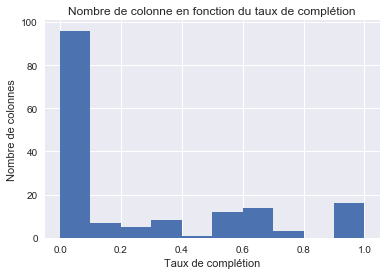

In [10]:
Tx_Col=[]
for Col in data.columns:
    if EvaluateCompletnessCOL(data[Col])is not None: 
        
        Tx_Col.append(float(EvaluateCompletnessCOL(data[Col])))
        
    else: 
        Tx_Col.append(0)
                     
plt.hist(Tx_Col)
plt.xlabel('Taux de complétion')
plt.ylabel('Nombre de colonnes')
plt.title('Nombre de colonne en fonction du taux de complétion')
plt.show


On voit bien ici que de nombreuses colonnes (~95) sont quasiment vides (moins de 10% de taux de complétion)
Pour la définition du seuil nous pouvons penser à deux choix : 
    - Seuil = 0.5 dans quel cas on travaillera avec des colonnes remplies à ~70% en moyenne
    - Seuil = O.85 dans quel cas on travaillera avec des colonnes quasiment complètes, mais en nombre très réduit. 
    
On choisit dans cette étude de travailler avec Seuil = 0.5 pour l'instant,
et par la suite d'essayer de remplir les valeurs manquantes si besoin

In [11]:
print(data.shape)
Ratio = 0.5
IsNull = pd.isnull(data)
ColSum = IsNull.sum(axis=0)   
ColSum 
Perc = np.zeros(len(ColSum))
for i in range(len(ColSum)):
    Perc[i] = np.around(ColSum[i]/data.shape[0],decimals = 3)

Col_to_keep = np.array(Perc<Ratio)

Col_to_del = np.array(Perc>Ratio)                
print(Col_to_del.sum())

# Création de la liste contenant le nom des colonnes à supprimer 
Del_List = []
for i in range(len(data.columns)):
    if Col_to_del[i] == True : 
        Del_List.append(data.columns[i])
        
print(len(Del_List))

# création du nouveau data set avec les colonnes contenant trop de valeurs "NaN" supprimées
new_data = data.drop(Del_List , axis=1)
print(new_data.shape)

(103082, 162)
117
117
(103082, 45)


In [12]:
print(Del_List)
# Il faut regarder si il n'y a pas de colonnes contenant des informations importantes par rapport au but du projet
# qui est in-fine de produire des recettes saines. 

# On peut par exemple penser aux variables sur les vitamines qui ont été supprimées ici

print(EvaluateCompletnessCOL(data['vitamin-c_100g']))
print(EvaluateCompletnessCOL(data['vitamin-a_100g']))
print(EvaluateCompletnessCOL(data['vitamin-b6_100g']))
print(EvaluateCompletnessCOL(data['vitamin-d_100g']))
print(EvaluateCompletnessCOL(data['calcium_100g']))
print(EvaluateCompletnessCOL(data['magnesium_100g']))
print(EvaluateCompletnessCOL(data['allergens']))
print(EvaluateCompletnessCOL(data['cholesterol_100g']))
print(EvaluateCompletnessCOL(data['nutrition_grade_fr']))
#print(EvaluateCompletnessCOL(data['']))

# Parmis ces colonnes, seule la variable "allergens" peut-être intéressante et présente "suffisamment" de données
# pour pouvoir être considérée

['generic_name', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'energy-from-fat_100g', 'butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'montanic-acid_100g', 'melissic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'alpha-linolenic-acid_100g', 'eicosapentaeno

Les valeurs nutritionnelles concernant les différentes vitamines sont loin de contenir assez de valeurs pour 
pouvoir être exploitées

#### Analyse des colonnes restantes

In [13]:
# Identification et séparation des variables numériques du nouveau data set 
new_data_float = new_data.select_dtypes(include=['float64'])
new_data_float.name = 'new_data_float'
print(new_data_float.shape)
print(new_data_float.columns)

(103082, 14)
Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g'],
      dtype='object')


In [14]:
new_data_object = new_data.select_dtypes(include=['object'])
print(new_data_object.shape)
print(new_data_object.columns)

(103082, 31)
Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity',
       'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories',
       'categories_tags', 'categories_fr', 'countries', 'countries_tags',
       'countries_fr', 'ingredients_text', 'additives', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_fr',
       'main_category', 'main_category_fr', 'image_url', 'image_small_url'],
      dtype='object')


Ici ce sont les valeurs nutritionnelles qui nous intéressent donc plus les valeurs numériques
Cependant pour que le data set garde un sens il faut conserver des informations textes sur le produit
Les variables suivantes semblent d'interet : 
'product_name', 'brands_tags', 'categories_fr', 'countries_fr', 'main_category_fr' et nutrition_grade_fr
Pour les besoins d'une recette nous pourrons peut-être avoir besoin de la variable 'quantity' également 

In [15]:
print(EvaluateCompletnessCOL(data['brands']))
print(EvaluateCompletnessCOL(data['brands_tags']))

0.9118565801982887
0.9117886730952057


In [16]:
# Création du data set avec les valeurs textes que nous désirons conserver
New_data_text = new_data[['categories_fr','brands_tags','main_category_fr','product_name',
                          'countries_fr','nutrition_grade_fr',]]
EvaluateCompletnessDF(New_data_text)

New_data_text = New_data_text.fillna(value = 'Non renseigné')
EvaluateCompletnessDF(New_data_text)

La matrice est complète à : 79.80000000000001 %
La matrice est complète à : 100.0 %


Convertion des variables numériques en valeurs numériques (pour éviter et detecter les erreurs)

In [17]:
# On va s'assurer que les colonnes finissant pour "_100g" soient bien au format float64

# Création de la fonction permettant de convertir en nombre une liste de colomne dans un dataframe
EvaluateCompletnessDF(new_data_float)
def convert_to_numeric(df, column_list):
       df[column_list].apply(pd.to_numeric, errors='coerce')

# errors='coerce' permet de remplacer une valeur non numérique en NaN, nous analysons donc le taux de complétion avant/après
ColNum = []   
for column in new_data.columns:
    if column[-5:] == "_100g":
        ColNum.append(column)    
print(ColNum)
convert_to_numeric(new_data_float,ColNum)
EvaluateCompletnessDF(new_data_float)

La matrice est complète à : 62.5 %
['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
La matrice est complète à : 62.5 %


Création du dataframe avec les colonnes retenues

In [18]:
# On réconcilie les data set textes et numériques
print(New_data_text.shape)
print(new_data_float.shape)
new_data = pd.concat([New_data_text,new_data_float],axis=1)
print(new_data.shape)

(103082, 6)
(103082, 14)
(103082, 20)


# Travail sur les lignes 

Suppression des lignes avec trop peu de données 

In [19]:
# Suppression des lignes en fonction de leur taux de remplissage
Row_Ratio = 0.4
print(new_data.shape)

# On enlève ici les lignes contenant au moins 60% (i.e au moins 12) de valeurs "NaN"
new_data = new_data.dropna(thresh = np.around(new_data.shape[1]*Row_Ratio))
print(new_data.shape)


(103082, 20)
(82767, 20)


Suppression des lignes avec valeurs négatives

In [20]:
print(new_data.shape)

print(new_data.shape)

(82767, 20)
(82767, 20)


Remplissage des valeurs manquantes par interpolation

In [21]:
EvaluateCompletnessDF(new_data)
new_data = new_data.interpolate()
EvaluateCompletnessDF(new_data)

La matrice est complète à : 84.5 %
La matrice est complète à : 100.0 %


Suppression des valeurs aberrantes : 
    - Valeurs supérieures à 100 pour les colonnes types "100_g" (sauf energy_100g)
    - Valeurs énergétiques supérieures à celle indiquée pour un produit contenant ~100 en fat_100g (+ marge erreur)
    

In [22]:
# Suppression des lignes si l'apport énergétique est trop important (110% de la valeur pour 100g de fat)
Test = new_data[new_data.fat_100g > 95]
Test.head(6)

# On voit que pour une valeur de 99.9 en fat_100g, le produit obtient ~3700 en kJ en energy_100g
# On peut donc penser à fixer le seuil à 4000 kJ pour la valeur energy_100g. 
# Les produits dépassant cette valeur seront considérés comme des anomalies.
print(new_data.shape)
new_data = new_data[new_data.energy_100g < 4000]
print(new_data.shape)

(82767, 20)
(82682, 20)


In [23]:
# On supprime ici les produits dont une des valeurs nutritionnelles présentes ...
# ... dans la liste ci-dessous est au dessus de 100
Liste_100 = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
             'proteins_100g', 'salt_100g', 'sodium_100g']
print(new_data.shape)
new_data = new_data[new_data['fat_100g'] < 100]
print(new_data.shape)
new_data = new_data[new_data['saturated-fat_100g'] < 100]
print(new_data.shape)
new_data = new_data[new_data['carbohydrates_100g'] < 100]
print(new_data.shape)
new_data = new_data[new_data['sugars_100g'] < 100]
print(new_data.shape)
new_data = new_data[new_data['fiber_100g'] < 100]
print(new_data.shape)
new_data = new_data[new_data['proteins_100g'] < 100]
print(new_data.shape)
new_data = new_data[new_data['salt_100g'] < 100]
print(new_data.shape)
new_data = new_data[new_data['sodium_100g'] < 100]
print(new_data.shape)

(82682, 20)
(82359, 20)
(82357, 20)
(82254, 20)
(82215, 20)
(82209, 20)
(82209, 20)
(82183, 20)
(82183, 20)


# Feature Engineering 
Création de nouvelles variables pertinentes

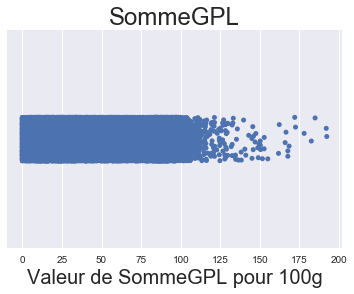

In [24]:
# Création de la variable SommeGPL (pour Somme Glucides Protéines Lipides)
SommeGPL = pd.Series(new_data.fat_100g + new_data.proteins_100g + new_data.carbohydrates_100g)
SommeGPL.describe()
sns.stripplot(SommeGPL, jitter = True)
plt.title('SommeGPL', fontsize = 24)
plt.xlabel('Valeur de SommeGPL pour 100g', fontsize = 20)
plt.show()
# Ajout de la colonne au dataframe
new_data['SommeGPL']= pd.Series(SommeGPL, index = new_data.index)

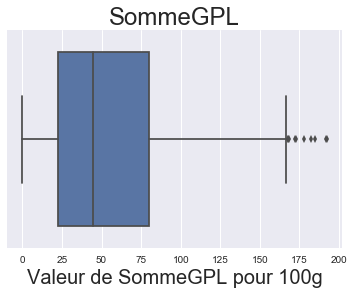

In [25]:
sns.boxplot(SommeGPL)
plt.title('SommeGPL', fontsize = 24)
plt.xlabel('Valeur de SommeGPL pour 100g', fontsize = 20)
plt.show()

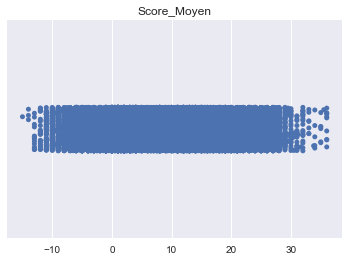

In [26]:
# Création de la variable score moyen 
Score_Moyen = pd.Series((new_data['nutrition-score-fr_100g'] + new_data['nutrition-score-uk_100g'])/2)
sns.stripplot(Score_Moyen, jitter = True)
plt.title('Score_Moyen')
plt.show()
new_data['Score_Moyen'] = pd.Series(Score_Moyen, index = new_data.index)

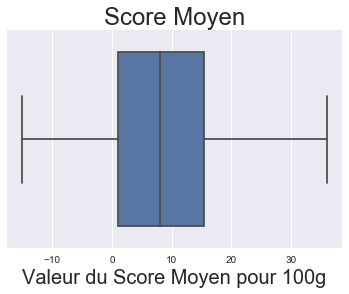

In [27]:
sns.boxplot(Score_Moyen)
plt.title('Score Moyen', fontsize = 24)
plt.xlabel('Valeur du Score Moyen pour 100g', fontsize = 20)
plt.show()

In [28]:
# Création d'une nouvelle variable en convertissant en Cal la colonne energy_100g
# 1 kJ = 0,23900574 kCal
new_data['kCal_100g'] = new_data.energy_100g * 0.239

Dernier Filtrage sur SommeGPL qui doit être inférieure à 100 selon les informations open food fact.   
Plus d'informations sur le sujet : https://fr.openfoodfacts.org/questions-frequentes

In [29]:
# Traitement si l'on souhate enlever tout les produits pour lesquels SommeGPL > 110
# On choisir 110 ici car on se donne une marge d'erreur liée au remplissage de certaines valeurs
Limite_SommeGPL = 110
print(new_data.shape)
new_data = new_data[new_data.SommeGPL < Limite_SommeGPL]
print(new_data.shape)

(82183, 23)
(82002, 23)


Nous avons un peu plus de 82000 produits dans notre jeu de données 

# Export de la base de données

In [30]:
new_data.to_csv(path_or_buf = 'C:/Users/flemeill/Documents/01 - Projets OC/02 - Projet 2/Main project/new_data_openfood.csv')